In [1]:
import pandas as pd
import geopandas
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import env
import split_scale as ss
import features as feat
import evaluate as ev

## Data Acquisition

In [2]:
query = '''
select *
from properties_2017
join predictions_2017 as pred
using(parcelid)
where pred.`transactiondate` like '%%-05-%%' or pred.`transactiondate` like '%%-06-%%'
'''
raw_df = pd.read_sql(query, env.get_db_url('zillow'))

In [3]:
raw_df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11393337,2463969,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,43439.0,2016.0,22755.0,756.94,Y,14.0,6.037235e+13,117,0.086137,2017-06-08
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21944 entries, 0 to 21943
Data columns (total 62 columns):
parcelid                        21944 non-null int64
id                              21944 non-null int64
airconditioningtypeid           7088 non-null float64
architecturalstyletypeid        49 non-null float64
basementsqft                    12 non-null float64
bathroomcnt                     21938 non-null float64
bedroomcnt                      21938 non-null float64
buildingclasstypeid             4 non-null float64
buildingqualitytypeid           13949 non-null float64
calculatedbathnbr               21762 non-null float64
decktypeid                      179 non-null float64
finishedfloor1squarefeet        1765 non-null float64
calculatedfinishedsquarefeet    21883 non-null float64
finishedsquarefeet12            20951 non-null float64
finishedsquarefeet13            12 non-null float64
finishedsquarefeet15            810 non-null float64
finishedsquarefeet50            17

In [5]:
raw_df = raw_df.drop('id', axis = 1)

- drop non-number columns

In [6]:
df = raw_df.select_dtypes(exclude=['object'])

- boolean columns (dummy variables)

In [7]:
df['has_pool'] = (df.poolcnt >= 1).astype(int)
df['has_yardbuilding'] = ((df.yardbuildingsqft17 >= 0)|(df.yardbuildingsqft26 >= 0)).astype(int)
df['has_fireplace'] = (df.fireplacecnt >= 1).astype(int)
df['has_basement'] = (df.basementsqft >= 1).astype(int)
df['has_garage'] = (df.garagecarcnt >= 1).astype(int)

- drop columns with insuffecient data

In [8]:
df = df[df.columns[df.isnull().mean() < 0.2]]

- drop redundant columns

In [9]:
df = df.drop('calculatedbathnbr', axis = 1).drop('finishedsquarefeet12', axis = 1).drop('fullbathcnt', axis = 1)

- drop columns with high correlation

In [10]:
df = df.drop('rawcensustractandblock', axis = 1).drop('structuretaxvaluedollarcnt', axis = 1).drop('landtaxvaluedollarcnt', axis = 1).drop('taxamount', axis = 1).drop('censustractandblock', axis = 1).drop('logerror', axis = 1)

- drop columns that represent categorical variables

In [11]:
df = df.drop('parcelid', axis = 1).drop('propertylandusetypeid', axis = 1).drop('regionidcity', axis = 1).drop('regionidcounty', axis = 1).drop('regionidzip', axis = 1).drop('fips', axis = 1)

- drop columns with no variance

In [12]:
df = df.drop('assessmentyear', axis = 1)

- drop nulls

In [13]:
df = df.dropna()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19581 entries, 0 to 21943
Data columns (total 14 columns):
bathroomcnt                     19581 non-null float64
bedroomcnt                      19581 non-null float64
calculatedfinishedsquarefeet    19581 non-null float64
latitude                        19581 non-null float64
longitude                       19581 non-null float64
lotsizesquarefeet               19581 non-null float64
roomcnt                         19581 non-null float64
yearbuilt                       19581 non-null float64
taxvaluedollarcnt               19581 non-null float64
has_pool                        19581 non-null int64
has_yardbuilding                19581 non-null int64
has_fireplace                   19581 non-null int64
has_basement                    19581 non-null int64
has_garage                      19581 non-null int64
dtypes: float64(9), int64(5)
memory usage: 2.2 MB


## Explore

- establish features and target

In [28]:
target = ['taxvaluedollarcnt']
feature = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
           'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'has_pool', 
           'has_yardbuilding', 'has_fireplace', 'has_basement', 'has_garage']

In [16]:
df.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt',
       'taxvaluedollarcnt', 'has_pool', 'has_yardbuilding', 'has_fireplace',
       'has_basement', 'has_garage'],
      dtype='object')

- check correlation
- bathroom count, bedroomcount, house squarefootage, year built, and having a pool seem to have the srtongest correlation with property value

In [17]:
df.corr()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage
bathroomcnt,1.000000,0.622210,0.759734,-0.003156,-0.003405,0.015360,0.037074,0.417113,0.468093,0.232607,0.021702,0.063431,0.006889,0.111402
bedroomcnt,0.622210,1.000000,0.598998,0.005083,0.048395,-0.140003,0.172586,0.134962,0.240394,0.090649,0.060585,0.121422,0.002110,0.174275
calculatedfinishedsquarefeet,0.759734,0.598998,1.000000,-0.055579,0.031069,-0.057602,0.095842,0.281711,0.571867,0.236032,0.039305,0.106897,0.008429,0.161908
latitude,-0.003156,0.005083,-0.055579,1.000000,-0.542190,0.096380,-0.252513,0.068519,-0.130317,0.033400,0.153172,-0.057309,0.022955,-0.429416
longitude,-0.003405,0.048395,0.031069,-0.542190,1.000000,-0.082549,-0.020334,0.038345,-0.016763,-0.041662,-0.391188,-0.208060,-0.046850,0.161764
lotsizesquarefeet,0.015360,-0.140003,-0.057602,0.096380,-0.082549,1.000000,-0.103279,0.133053,-0.020041,0.153252,-0.026155,-0.065593,-0.000941,-0.131188
roomcnt,0.037074,0.172586,0.095842,-0.252513,-0.020334,-0.103279,1.000000,0.105798,0.002350,0.029481,0.346307,0.673072,0.043943,0.802991
yearbuilt,0.417113,0.134962,0.281711,0.068519,0.038345,0.133053,0.105798,1.000000,0.137486,0.126456,0.071203,0.127661,-0.008419,0.262016
taxvaluedollarcnt,0.468093,0.240394,0.571867,-0.130317,-0.016763,-0.020041,0.002350,0.137486,1.000000,0.174155,-0.001038,0.018737,0.000629,0.065756
has_pool,0.232607,0.090649,0.236032,0.033400,-0.041662,0.153252,0.029481,0.126456,0.174155,1.000000,0.002262,0.033068,-0.003817,-0.006146


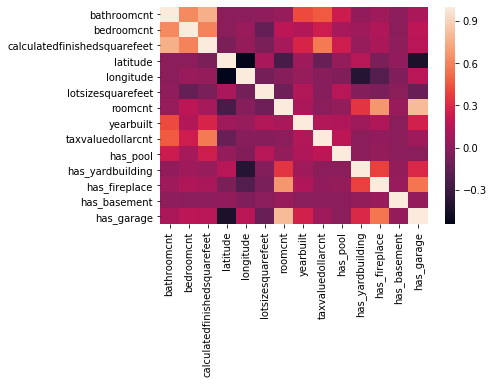

In [18]:
sns.heatmap(df.corr())

- average price by year built

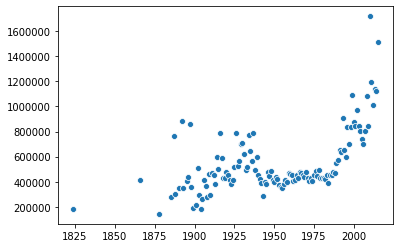

In [19]:
sns.scatterplot(data = df.groupby('yearbuilt').mean().taxvaluedollarcnt)

- average price by house size

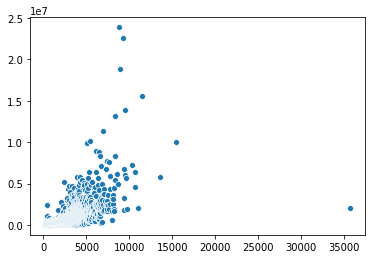

In [20]:
sns.scatterplot(data = df.groupby('calculatedfinishedsquarefeet').mean().taxvaluedollarcnt)

- average price by bedroom count

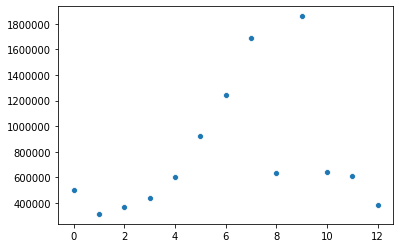

In [21]:
sns.scatterplot(data = df.groupby('bedroomcnt').mean().taxvaluedollarcnt)

- average price by bathroom count

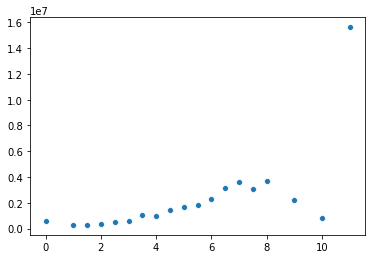

In [22]:
sns.scatterplot(data = df.groupby('bathroomcnt').mean().taxvaluedollarcnt)

- averge price by room count

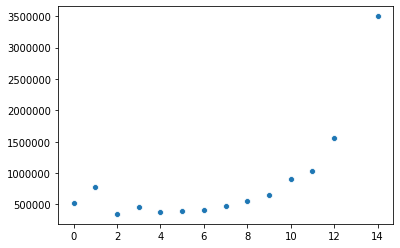

In [23]:
sns.scatterplot(data = df.groupby('roomcnt').mean().taxvaluedollarcnt)

- average price by lot size
- does not appeat to have a strong linear coorelation

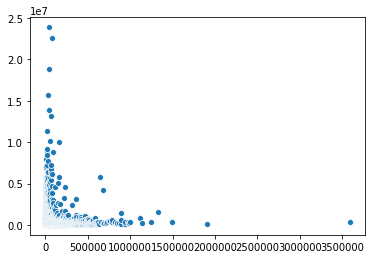

In [24]:
sns.scatterplot(data = df.groupby('lotsizesquarefeet').mean().taxvaluedollarcnt)

## Feature Engineering

In [25]:
train, test = ss.split_my_data(df)

In [26]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage
5712,1.0,2.0,951.0,33799245.0,-118131330.0,6593.0,0.0,1954.0,445887.0,0,0,0,0,0
8156,3.0,4.0,2773.0,34253354.0,-118608821.0,7504.0,0.0,1978.0,506508.0,1,0,0,0,0
6864,3.0,3.0,2154.0,34174378.0,-118643702.0,12236.0,0.0,1960.0,396208.0,1,0,0,0,0
124,2.0,3.0,1520.0,33735811.0,-118299299.0,5402.0,0.0,1929.0,299491.0,0,0,0,0,0
17218,3.0,3.0,1460.0,34216600.0,-118242000.0,31239.0,0.0,1982.0,471800.0,1,0,0,0,0


In [29]:
feat.lasso_cv_coef(train[feature], train[target])

bathroomcnt                       0.000000
bedroomcnt                       -0.000000
calculatedfinishedsquarefeet    351.170101
latitude                         -0.441880
longitude                        -0.245579
lotsizesquarefeet                 0.086533
roomcnt                          -0.000000
yearbuilt                         0.000000
has_pool                          0.000000
has_yardbuilding                 -0.000000
has_fireplace                    -0.000000
has_basement                     -0.000000
has_garage                       -0.000000
dtype: float64

In [30]:
feat.ols_backward_elimination(train[feature], train[target])

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'roomcnt',
 'yearbuilt',
 'has_pool',
 'has_garage']

In [31]:
_,_, features = feat.recursive_feature_elimination(feature, target, df)
features

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'roomcnt', 'yearbuilt', 'has_pool', 'has_yardbuilding',
       'has_fireplace', 'has_basement', 'has_garage'],
      dtype='object')

- same tests but this time: scaled data

In [35]:
scaler ,trainx_scaled, testx_scaled = ss.standard_scaler(train[features], test[features])

In [36]:
feat.lasso_cv_coef(trainx_scaled, train[target])

bathroomcnt                     111790.890508
bedroomcnt                     -106486.817630
calculatedfinishedsquarefeet    359318.725474
latitude                       -121224.857177
longitude                       -85688.396886
roomcnt                         -28281.038644
yearbuilt                       -23032.793816
has_pool                         19175.830611
has_yardbuilding                 -4831.400407
has_fireplace                   -15635.143359
has_basement                      -741.135338
has_garage                       -7780.409584
dtype: float64

In [38]:
feature = feat.ols_backward_elimination(trainx_scaled, train[target])
feature

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'roomcnt',
 'yearbuilt',
 'has_pool',
 'has_fireplace']

## Model